<a href="https://colab.research.google.com/github/droidadroit/age-and-gender-classification/blob/master/AgeGender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is the implementation of [Age and Gender Classification by Gil Levi and Tal Hassner](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf) using PyTorch as the deep learning framework and Google Colab as the training ground. The network proposed in the paper has five convolutional layers and three fully connected layers, and is simple enough to understand and get familiar with PyTorch and Colab. Try it!

Instead, if you just want to test the model on an image, go to the **Testing on an image** section.

# Setup

Ensure that you are using Python 3.6 and GPU as the hardware accelerator. To check this, go to **Runtime -> Change runtime type** in the menu bar of Colab.

## Mounting the drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## Directory structure
Our project is in the directory **AgeGenderClassification**. Create this directory and the sub-directories inside it along with the downloaded **AgeGender.ipynb**.

content  
-------- gdrive  
---------------- My Drive  
------------------------ **AgeGenderClassification**  
-------------------------------- **data**  
-------------------------------- **models**  
-------------------------------- **results**  
-------------------------------- **AgeGender.ipynb**


## Installing PyTorch
This script installs PyTorch and torchvision.

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

## Imports

In [0]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

## **Raw data**



### Downloading data


We use the Adience dataset consisting unfiltered faces ([Link](http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz)). Then, we unzip it.  
The first cell below downloads the data for you and places it in the **data** directory. The second cell unzips the data.

In [0]:
!wget --user adiencedb --password adience http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz -P "/content/gdrive/My Drive/AgeGenderClassification/data"

In [0]:
!tar xvzf "/content/gdrive/My Drive/AgeGenderClassification/data/aligned.tar.gz" -C "/content/gdrive/My Drive/AgeGenderClassification/data/"

### Downloading folds

All five folds used in this paper are present [here](https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold). Download the **train_val_txt_files_per_fold** folder and place it in **My Drive/AgeGenderClassification/data**.


## Data loading

In [0]:
PATH_TO_FOLDS = "/content/gdrive/My Drive/AgeGenderClassification/data/train_val_txt_files_per_fold"
PATH_TO_DATA = "/content/gdrive/My Drive/AgeGenderClassification/data"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "/aligned"

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.

[This](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a useful tutorial on how to load and augment data in PyTorch. 

In [0]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }         

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [0]:
transforms_list = [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(227)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [0]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS
    
    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=4)
    
    return dataloader

# Network

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
PATH_TO_MODELS = "/content/gdrive/My Drive/AgeGenderClassification/models"

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 10)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [0]:
criterion = nn.NLLLoss()

## Hyperparameters
Try playing with these! While the **`minibatch_size`** and **`lr`** are pulled from the paper, **`num_epochs`** is set empirically. 

In [0]:
minibatch_size = 50
num_epochs = 60
lr = 0.0001  # initial learning rate

## Training the network
We save the network to the drive and compute the loss on validation set after every **`checkpoint_frequency`** number of iterations. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [0]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency, val_dataloader=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
                                    
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                training_loss.append(running_loss/checkpoint_frequency)
                validation_loss.append(validate(net, val_dataloader))
                print(f'minibatch:{i}, epoch:{epoch}, iteration:{iteration}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')
                save_network(net, f'{filename}_checkpoint{checkpoint}')
                checkpoint += 1
                running_loss = 0
            
            iteration += 1

    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [0]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [0]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [0]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result           

## Saving the network

In [0]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function and then, using the validation losses returned by this function at all checkpoints, chooses the model with least validation error. This function also plots a graph of training and validation errors over the iterations.

**Usage:**

For e.g., if you want to train the network for **`age`** using **`fold=2`** and **`train_transform_index=2`**,
```
train_save('age', 2, 2)
```



In [0]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    trained_net, training_loss, validation_loss = train(
        Net().to(device),
        get_dataloader('train', c, fold, train_transform_index, minibatch_size),
        num_epochs,
        f'{fold}_{c}_train_{train_transform_index}',
        checkpoint_frequency,
        get_dataloader('val', c, fold, 0, minibatch_size)
    )
    
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(validation_loss)+1))))), validation_loss, label='validation_loss')
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(training_loss)+1))))), training_loss, label='training_loss')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    
    choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)
    
    return validation_loss

In [0]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory. 

**Usage:**

To pick the best model for **`age`**,
```
pick_best_model('age')
```


To pick the best model for **`gender`**,

```
pick_best_model('gender')
```

In [0]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.

**Usage:**

To know the performance on **`age`** classification,
```
get_performance('age')
```


To know the performance on **`gender`** classification,

```
get_performance('gender')
```



In [0]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [0]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [0]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    performance = test(
        net,
        get_dataloader(s, c, fold, 0, minibatch_size),
        c
    )
    if c == 'age':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total']
        }
    elif c == 'gender':
        return {
            'accuracy': performance['exact_match']/performance['total']
        }

In [0]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

### How to run?

1.   **Run `train_save()`:**


> You can do this for different combinations of **`c`**, **`fold`**, and **`train_transform_index`**, where **`c={'age','gender'}`**, **`fold={0,1,2,3,4}`**, and **`train_transform_index={0,1,2}`**.

> I suggest you to first train the network on all the folds for **either** **`age`** or **`gender`** and then proceed to the setp 2. Then, follow the same steps for the other class. Also, use **`train_transform_index=2`** as it gives smaller validation error due to random flipping and cropping.

> **Note:** It is just the network's architecture that is the same for age and gender. They both are trained independently. Ultimately, we will be having two different networks with the same architecture, one to classify age and the other to classify gender.

2. **Picking the best model:**

> Call **`pick_best_model()`** on either **`age`** or **`gender`**.

3. **Know the performance:**

> Call **`get_performance()`** on either **`age`** or **`gender`** to know the final performance of the network on the test set.





# Results

## Age

### Plots of validation and training losses:
These are graphs we get on calling **`train_save()`** on age for different folds.

####  **Fold 0**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1ulisa-NML3TgublIxt9rVm9OveVFJXuh)

---

####  **Fold 1**
![Training and validation loss over the iterations for fold 1](https://drive.google.com/uc?export=view&id=1vKPPim8jyuwCmgy-tN05xtaAW5611j7Y)

---

####  **Fold 2**
![Training and validation loss over the iterations for fold 2](https://drive.google.com/uc?export=view&id=1NpxIX9BqviCnOPQtJsD1Ei91aB1jFY33)

---

####  **Fold 3**
![Training and validation loss over the iterations for fold 3](https://drive.google.com/uc?export=view&id=1mA_LqHCfTv_LkajI3u9Qg5uMSYtlsX5p)

---

####  **Fold 4**
![Training and validation loss over the iterations for fold 3](https://drive.google.com/uc?export=view&id=1gmmq5qDsRXZjM71N2-IN6B_1fjaJTrUA)



### Accuracy
These are the accurcies we get on calling **`get_performance()`** on **`age`**.

```
{'accuracy': 0.5272136474411048, 'one-off accuracy': 0.8399675060926076}
```



## Gender

### Plots of validation and training losses:
These are graphs we get on calling **`train_save()`** on gender for different folds.

 ####  **Fold 0**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1C4YkqeFhzCo_VCcXHivacmsds-bl_3Ax)

---

####  **Fold 1**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1SQoRSeQ1x7fGrTTWhQxiX6hEpCuvM5_1)

---

####  **Fold 2**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1IOVldcO5o2vEgBVBdJAKaOAg_IRNMtyJ)

---

####  **Fold 3**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1nEqhwU4APKYzB5XcLrQdmDyzO5qoESLh)

---

####  **Fold 4**
![Training and validation loss over the iterations for fold 0](https://drive.google.com/uc?export=view&id=1uiRoVhlaaDQLoEAGGFzxkTY4HmDK84fc)

### Accuracy
This is the accuracy we get on calling **`get_performance()`** on **`gender`**.

```
{'accuracy': 0.8437770719029744}
```



# Testing on an image

You can either download the trained models for age and gender classification from [here](https://github.com/droidadroit/age-and-gender-classification/tree/master/models) into the **models** directory or rename the best models for age and gender upon training with **age.pt** and **gender.pt** respectively.


For the prediction of age and gender from an image, simply call **`test()`** providing the path (in your Google Drive) of the image as the argument.

**Usage:**  
`test("/content/gdrive/My Drive/AgeGenderClassification/test.jpeg")`

In [0]:
PATH_TO_AGE_MODEL = f'{PATH_TO_MODELS}/age.pt'
PATH_TO_GENDER_MODEL = f'{PATH_TO_MODELS}/gender.pt'

In [0]:
mapping = {
    0: '0-2 years',
    1: '4-6 years',
    2: '8-13 years',
    3: '15-20 years',
    4: '25-32 years',
    5: '38-43 years',
    6: '48-53 years',
    7: '60 years and above',
    8: 'male',
    9: 'female'
}

In [0]:
def test_on_a_class(c, image_tensor):
    with torch.no_grad():
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{c}.pt'))
        net.eval()       
        output = net(image_tensor)
        output = torch.max(output, 1)[1].to(device)
        result = f'{c} = {mapping[output.item()]}'

    return result    

In [0]:
def test(path):
    image = Image.open(path)
    plt.imshow(image)
    image = transforms.Compose(transforms_dict['test'][0])(image)
    image.unsqueeze_(0)
    image = image.to(device)
    print(test_on_a_class('age', image))
    print(test_on_a_class('gender', image))

## Examples

age = 25-32 years
gender = male


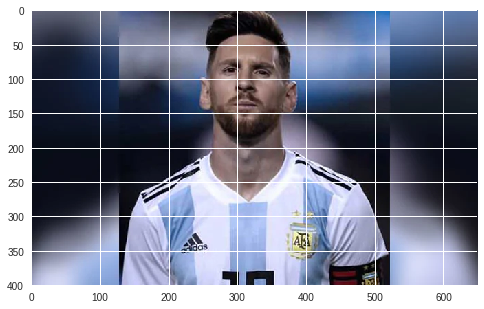

In [0]:
test("/content/gdrive/My Drive/AgeGenderClassification/test2.jpg")

age = 15-20 years
gender = female


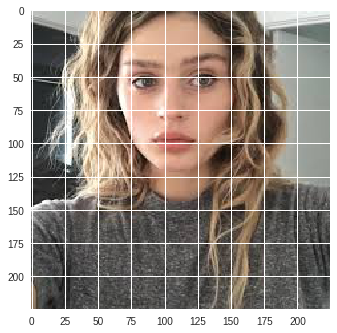

In [0]:
test("/content/gdrive/My Drive/AgeGenderClassification/test6.jpeg")

# Issues while running:


* 
**```
AttributeError: module 'PIL.Image' has no attribute 'register_extensions'
```**


> In such cases, restart the runtime by pressing **Ctrl + M** or going to **Runtime->Restart runtime** in the menu bar of Colab. Then, run the code again.




